In [ ]:
from types import new_class
import gym

# Initialize environment with new_step_api=True to use the new API
env = gym.make("MountainCar-v0", new_step_api=True)

state = env.reset()
done = False
while not done:
    action = env.action_space.sample()  # Random action
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    print(f"State: {state}, Action: {action}, Reward: {reward}")
    state = next_state



State: [-0.53178585  0.        ], Action: 2, Reward: -1.0
State: [-0.53072447  0.0010614 ], Action: 0, Reward: -1.0
State: [-5.30609608e-01  1.14835144e-04], Action: 0, Reward: -1.0
State: [-0.53144217 -0.00083259], Action: 1, Reward: -1.0
State: [-0.53221595 -0.00077377], Action: 2, Reward: -1.0
State: [-5.3192508e-01  2.9085428e-04], Action: 2, Reward: -1.0
State: [-0.5305718  0.0013533], Action: 0, Reward: -1.0
State: [-5.3016621e-01  4.0558915e-04], Action: 1, Reward: -1.0
State: [-5.2971137e-01  4.5484176e-04], Action: 1, Reward: -1.0
State: [-5.2921069e-01  5.0068373e-04], Action: 1, Reward: -1.0
State: [-0.5286679   0.00054277], Action: 2, Reward: -1.0
State: [-0.52708715  0.00158079], Action: 2, Reward: -1.0
State: [-0.52448016  0.00260695], Action: 2, Reward: -1.0
State: [-0.52086663  0.00361356], Action: 1, Reward: -1.0
State: [-0.51727355  0.00359307], Action: 2, Reward: -1.0
State: [-0.5127279   0.00454563], Action: 2, Reward: -1.0
State: [-0.5072638   0.00546412], Action: 

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


# MountainCar-v0

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gym
import matplotlib.pyplot as plt
from collections import deque
import random

# Define the DQN model
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Hyperparameters
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
target_update = 10
num_episodes = 1000

# Experience replay buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Train the DQN on MountainCar-v0
def train_dqn(env_name="MountainCar-v0", learning_rate=0.001):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    # Initialize DQN networks and optimizer
    policy_net = DQN(state_dim, action_dim)
    target_net = DQN(state_dim, action_dim)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    replay_buffer = ReplayBuffer(capacity=10000)

    # List to store total rewards for each episode
    episode_rewards = []

    # Training loop
    global epsilon
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)

            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action = policy_net(state_tensor).argmax().item()

            # Step the environment
            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            # Store transition in replay buffer
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state

            # Sample from replay buffer and update policy network
            if len(replay_buffer) >= batch_size:
                batch = replay_buffer.sample(batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)

                states = torch.FloatTensor(states)
                actions = torch.LongTensor(actions).unsqueeze(1)
                rewards = torch.FloatTensor(rewards)
                next_states = torch.FloatTensor(next_states)
                dones = torch.FloatTensor(dones)

                # Compute Q values
                q_values = policy_net(states).gather(1, actions).squeeze()
                with torch.no_grad():
                    next_q_values = target_net(next_states).max(1)[0]
                    target_q_values = rewards + gamma * next_q_values * (1 - dones)

                # Compute loss and update network
                loss = nn.MSELoss()(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Epsilon decay
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        # Update target network
        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        episode_rewards.append(total_reward)

        # Print progress
        if episode % 50 == 0:
            print(f"Episode {episode + 1}: Total Reward = {total_reward}, Epsilon = {epsilon:.2f}")

    return episode_rewards,policy_net

learning_rates = [0.001, 0.0005, 0.0001, 0.005]
all_rewards = []

# Train with each learning rate and store the rewards
for lr in learning_rates:
    rewards,_ = train_dqn("MountainCar-v0", learning_rate=lr)
    all_rewards.append(rewards)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-1-ccebe47a8032>:94: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarra

Episode 1: Total Reward = -200.0, Epsilon = 0.99
Episode 51: Total Reward = -200.0, Epsilon = 0.77
Episode 101: Total Reward = -200.0, Epsilon = 0.60
Episode 151: Total Reward = -200.0, Epsilon = 0.47
Episode 201: Total Reward = -200.0, Epsilon = 0.37
Episode 251: Total Reward = -200.0, Epsilon = 0.28
Episode 301: Total Reward = -200.0, Epsilon = 0.22
Episode 351: Total Reward = -200.0, Epsilon = 0.17
Episode 401: Total Reward = -200.0, Epsilon = 0.13
Episode 451: Total Reward = -200.0, Epsilon = 0.10
Episode 501: Total Reward = -170.0, Epsilon = 0.08
Episode 551: Total Reward = -147.0, Epsilon = 0.06
Episode 601: Total Reward = -96.0, Epsilon = 0.05
Episode 651: Total Reward = -154.0, Epsilon = 0.04
Episode 701: Total Reward = -93.0, Epsilon = 0.03
Episode 751: Total Reward = -164.0, Epsilon = 0.02
Episode 801: Total Reward = -188.0, Epsilon = 0.02
Episode 851: Total Reward = -114.0, Epsilon = 0.01
Episode 901: Total Reward = -105.0, Epsilon = 0.01
Episode 951: Total Reward = -95.0, E

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 1: Total Reward = -200.0, Epsilon = 0.01
Episode 51: Total Reward = -200.0, Epsilon = 0.01
Episode 101: Total Reward = -200.0, Epsilon = 0.01
Episode 151: Total Reward = -200.0, Epsilon = 0.01
Episode 201: Total Reward = -200.0, Epsilon = 0.01
Episode 251: Total Reward = -200.0, Epsilon = 0.01
Episode 301: Total Reward = -148.0, Epsilon = 0.01
Episode 351: Total Reward = -200.0, Epsilon = 0.01
Episode 401: Total Reward = -135.0, Epsilon = 0.01
Episode 451: Total Reward = -171.0, Epsilon = 0.01
Episode 501: Total Reward = -138.0, Epsilon = 0.01
Episode 551: Total Reward = -140.0, Epsilon = 0.01
Episode 601: Total Reward = -186.0, Epsilon = 0.01
Episode 651: Total Reward = -154.0, Epsilon = 0.01
Episode 701: Total Reward = -137.0, Epsilon = 0.01
Episode 751: Total Reward = -92.0, Epsilon = 0.01
Episode 801: Total Reward = -87.0, Epsilon = 0.01
Episode 851: Total Reward = -200.0, Epsilon = 0.01
Episode 901: Total Reward = -200.0, Epsilon = 0.01
Episode 951: Total Reward = -200.0, 

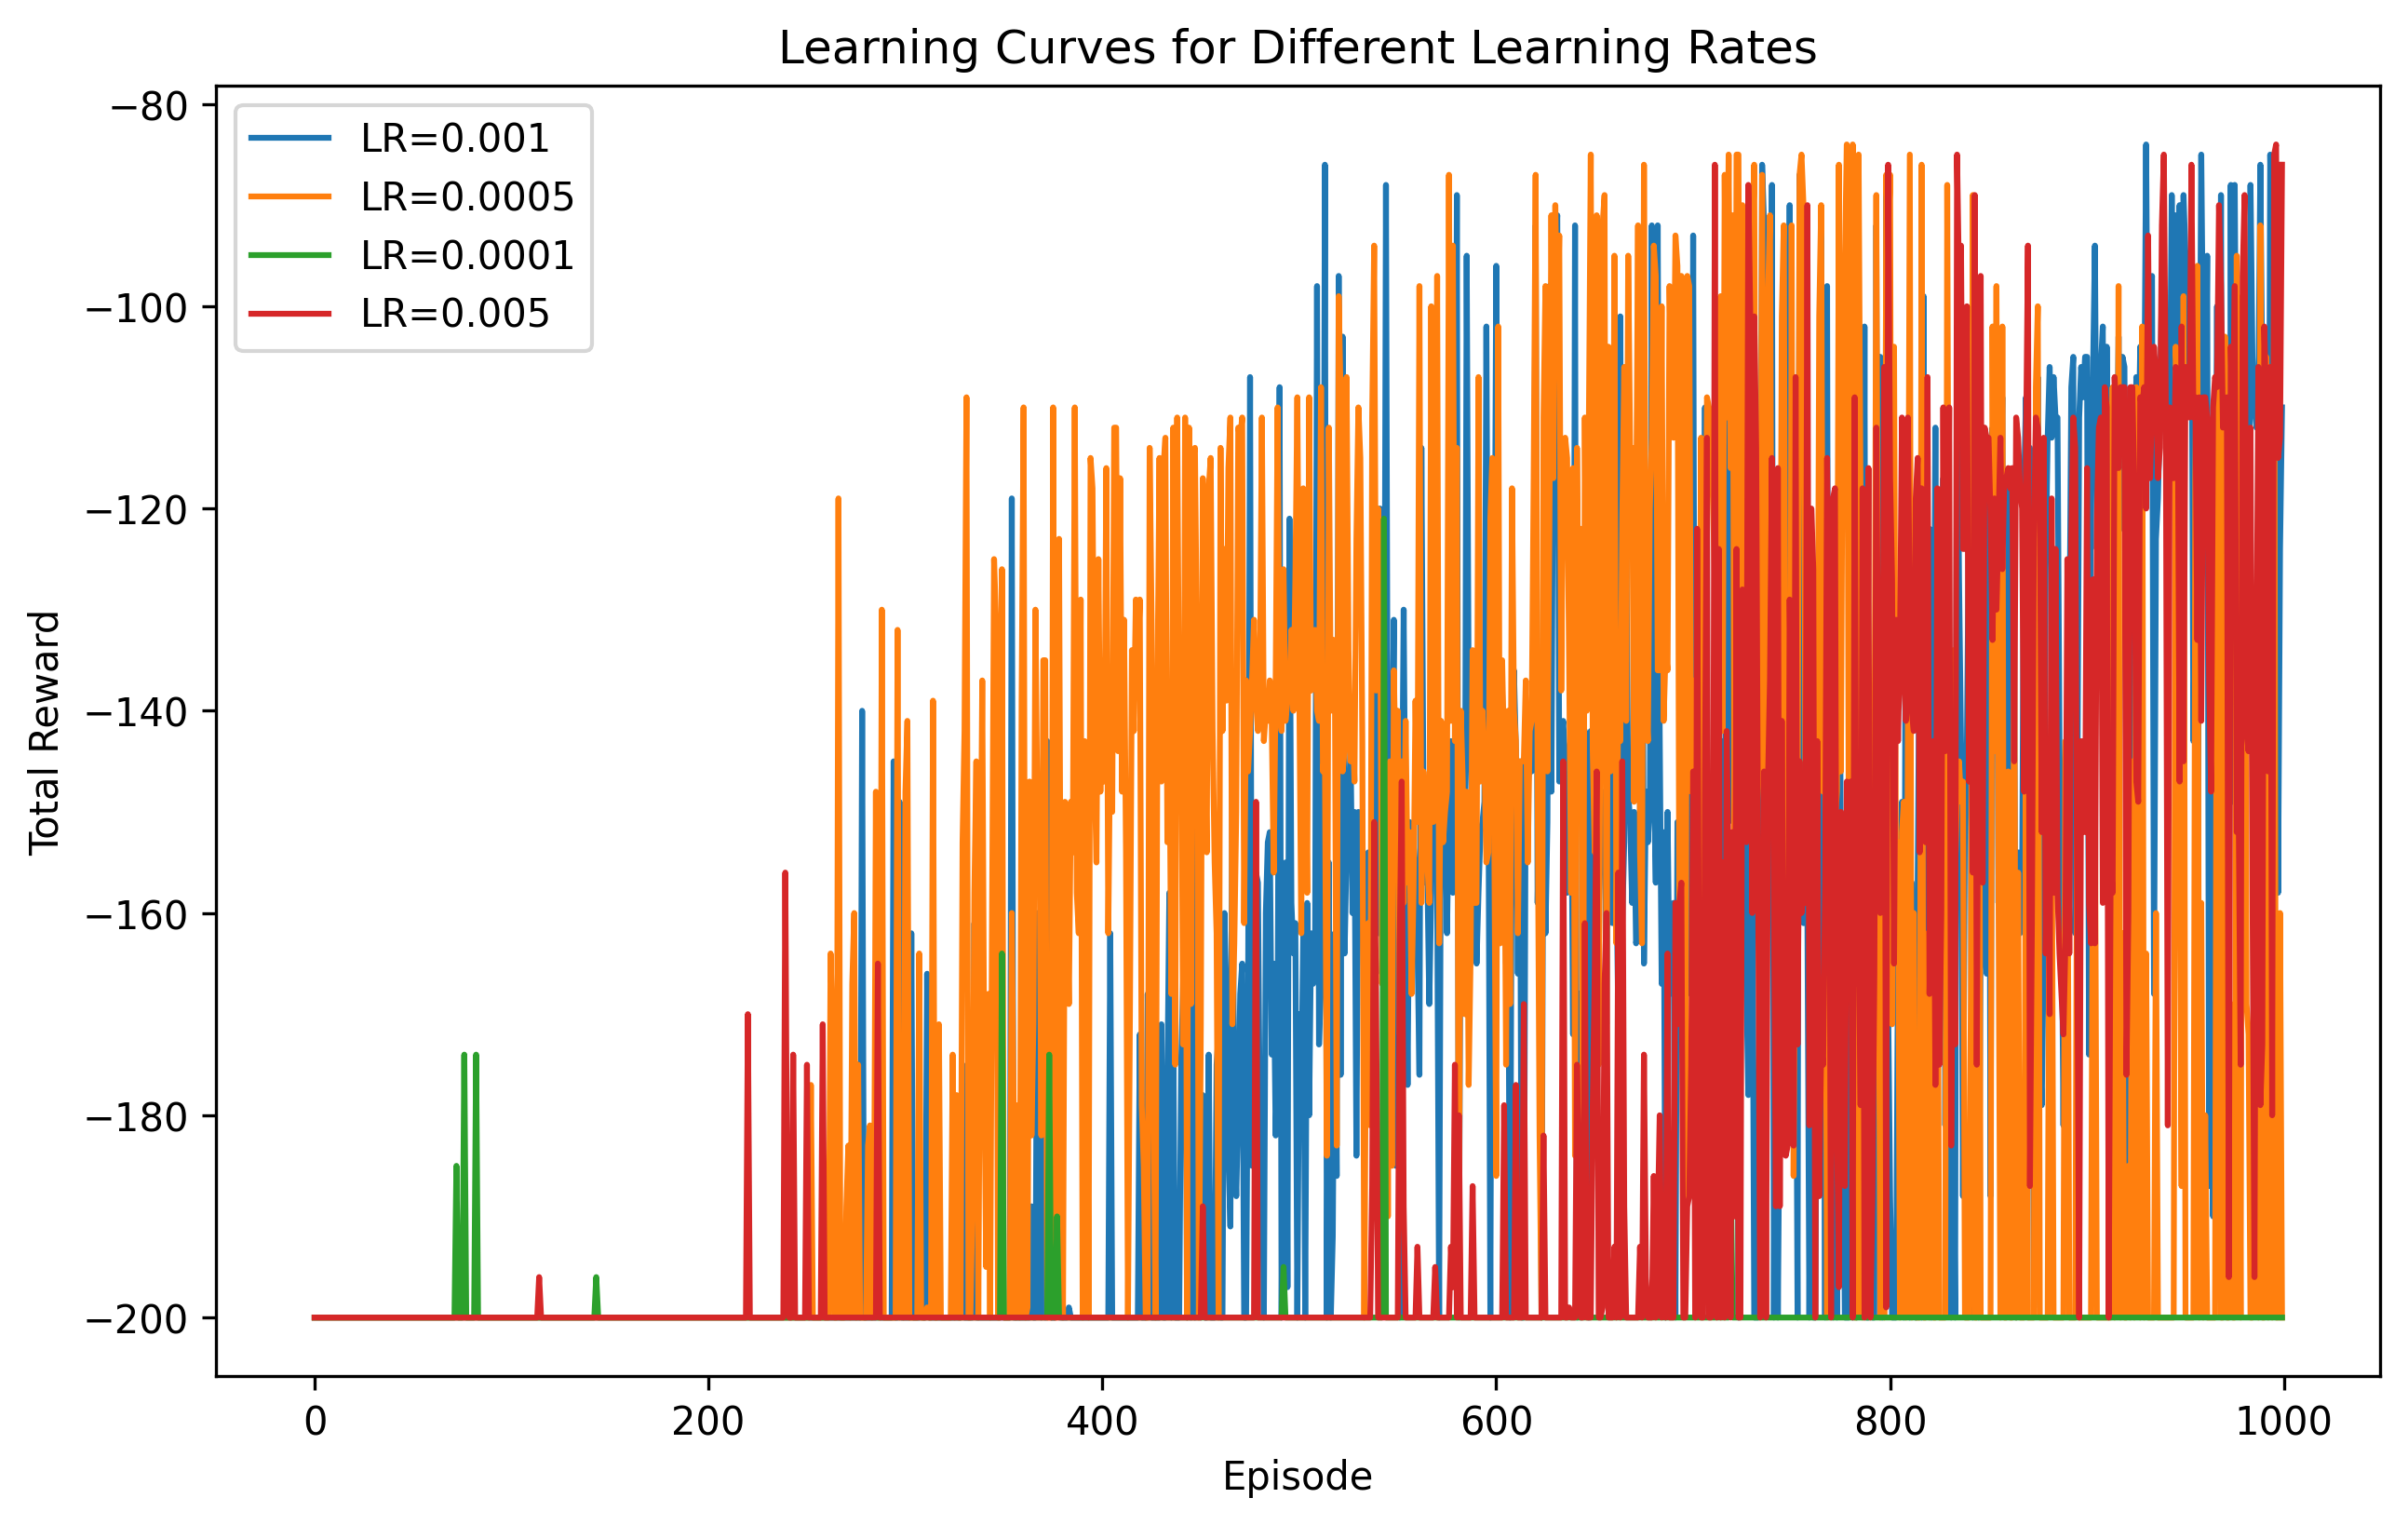

In [3]:
# Plot the learning curves
plt.figure(figsize=(10, 6),dpi = 300)
for i, lr in enumerate(learning_rates):
    plt.plot(all_rewards[i], label=f"LR={lr}")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Learning Curves for Different Learning Rates")
plt.legend()
plt.show()

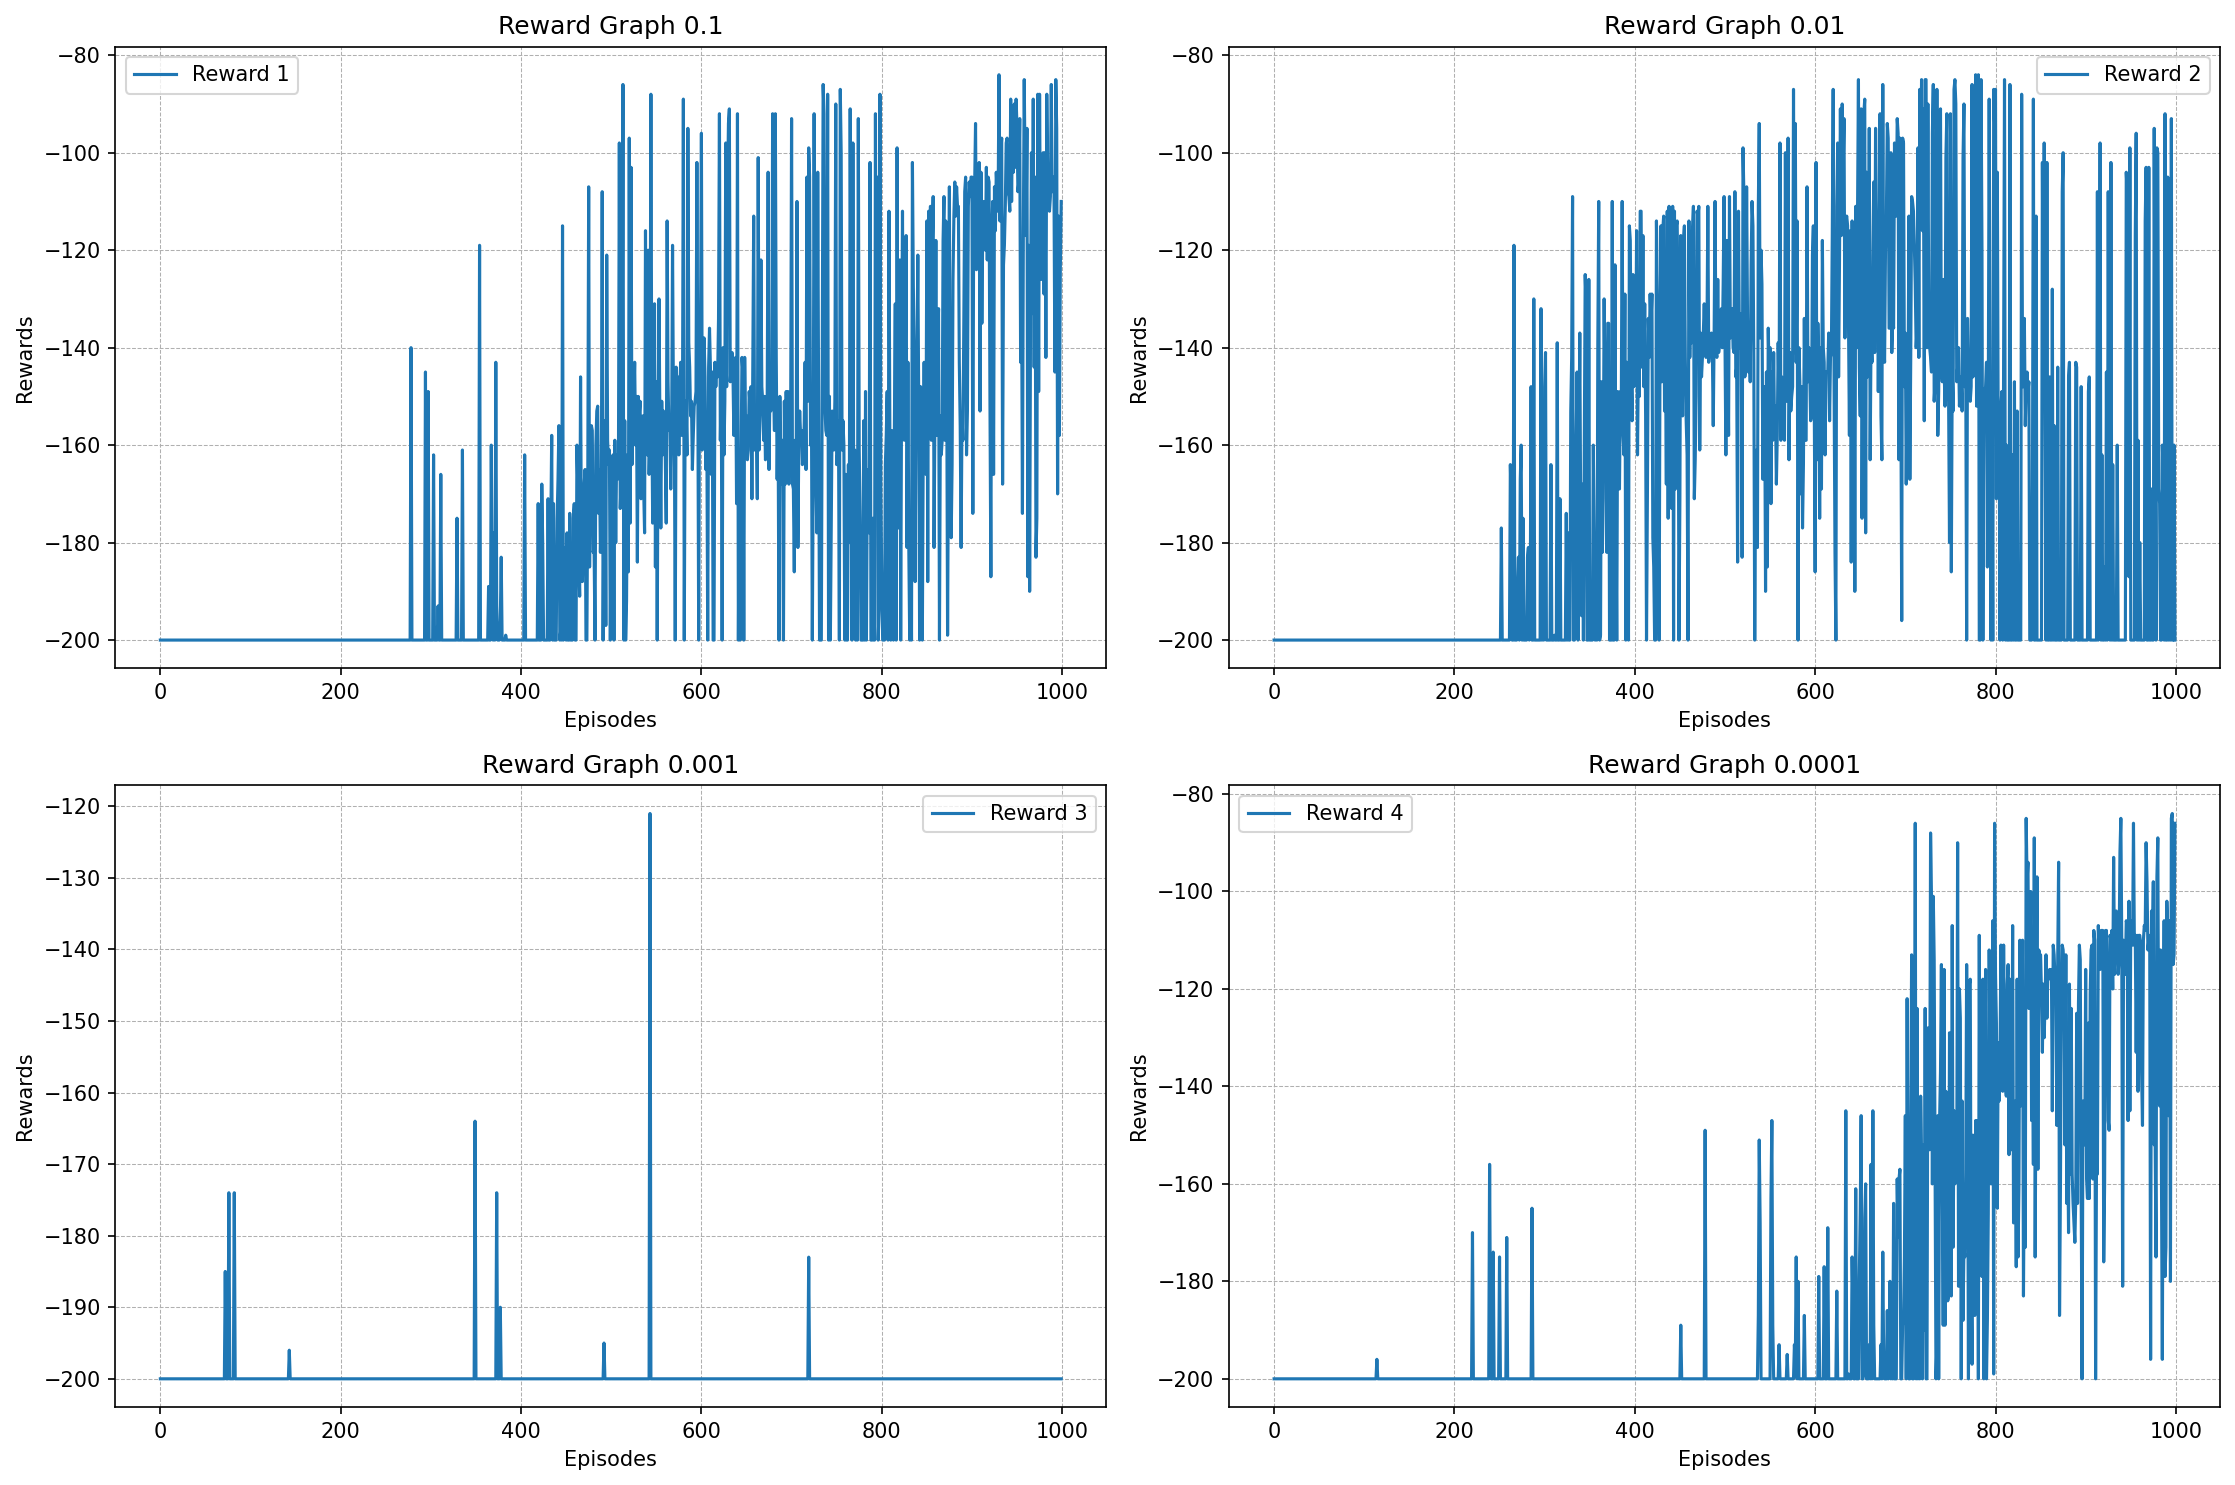

In [4]:
lr = [1e-1,1e-2,1e-3,1e-4]
fig, axes = plt.subplots(2, 2, figsize=(15, 10), dpi=150)  # 2x2 grid of subplots
axes = axes.flatten()

for i in range(4):
        # Plot on each subplot
    axes[i].plot(all_rewards[i], label=f'Reward {i+1}')
    axes[i].set_xlabel('Episodes')
    axes[i].set_ylabel('Rewards')
    axes[i].set_title(f'Reward Graph {lr[i]}')
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [5]:
def train_dqn(env_name="MountainCar-v0", learning_rate=0.001):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    # Initialize DQN networks and optimizer
    policy_net = DQN(state_dim, action_dim)
    target_net = DQN(state_dim, action_dim)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    replay_buffer = ReplayBuffer(capacity=10000)

    # List to store total rewards for each episode
    episode_rewards = []

    # Training loop
    global epsilon
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)

            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action = policy_net(state_tensor).argmax().item()

            # Step the environment
            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            # Store transition in replay buffer
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state

            # Sample from replay buffer and update policy network
            if len(replay_buffer) >= batch_size:
                batch = replay_buffer.sample(batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)

                states = torch.FloatTensor(states)
                actions = torch.LongTensor(actions).unsqueeze(1)
                rewards = torch.FloatTensor(rewards)
                next_states = torch.FloatTensor(next_states)
                dones = torch.FloatTensor(dones)

                # Compute Q values
                q_values = policy_net(states).gather(1, actions).squeeze()
                with torch.no_grad():
                    next_q_values = target_net(next_states).max(1)[0]
                    target_q_values = rewards + gamma * next_q_values * (1 - dones)

                # Compute loss and update network
                loss = nn.MSELoss()(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Epsilon decay
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        # Update target network
        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        episode_rewards.append(total_reward)

        # Print progress
        if episode % 50 == 0:
            print(f"Episode {episode + 1}: Total Reward = {total_reward}, Epsilon = {epsilon:.2f}")

    return episode_rewards,policy_net

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

Episode 1: Total Reward = -200.0, Epsilon = 0.01
Episode 51: Total Reward = -200.0, Epsilon = 0.01
Episode 101: Total Reward = -200.0, Epsilon = 0.01
Episode 151: Total Reward = -200.0, Epsilon = 0.01
Episode 201: Total Reward = -200.0, Epsilon = 0.01
Episode 251: Total Reward = -200.0, Epsilon = 0.01
Episode 301: Total Reward = -157.0, Epsilon = 0.01
Episode 351: Total Reward = -90.0, Epsilon = 0.01
Episode 401: Total Reward = -148.0, Epsilon = 0.01
Episode 451: Total Reward = -89.0, Epsilon = 0.01
Episode 501: Total Reward = -144.0, Epsilon = 0.01
Episode 551: Total Reward = -134.0, Epsilon = 0.01
Episode 601: Total Reward = -135.0, Epsilon = 0.01
Episode 651: Total Reward = -137.0, Epsilon = 0.01
Episode 701: Total Reward = -140.0, Epsilon = 0.01
Episode 751: Total Reward = -197.0, Epsilon = 0.01
Episode 801: Total Reward = -111.0, Epsilon = 0.01
Episode 851: Total Reward = -138.0, Epsilon = 0.01
Episode 901: Total Reward = -200.0, Epsilon = 0.01
Episode 951: Total Reward = -200.0, 

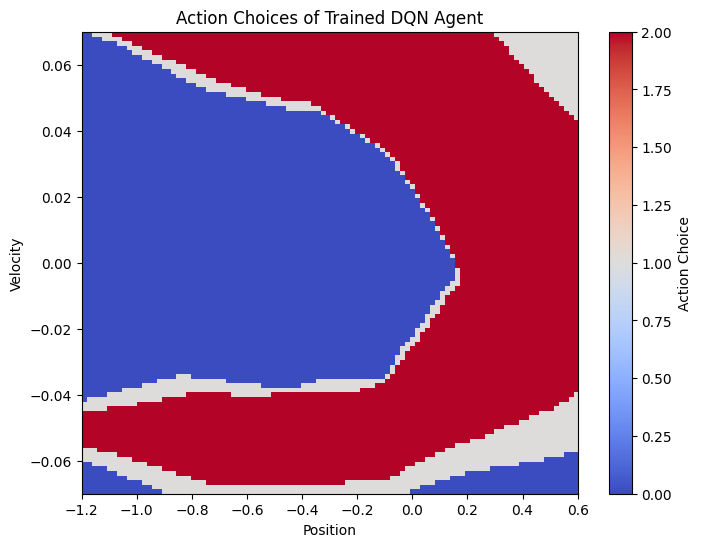

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Function to plot action choices
def plot_action_choices(policy_net, env):
    # Create a grid of position and velocity values
    position_values = np.linspace(-1.2, 0.6, 100)  # MountainCar-v0 position range
    velocity_values = np.linspace(-0.07, 0.07, 100)  # MountainCar-v0 velocity range
    action_grid = np.zeros((100, 100))

    # Iterate over the grid and compute the action choice for each (position, velocity)
    for i, position in enumerate(position_values):
        for j, velocity in enumerate(velocity_values):
            state = np.array([position, velocity])
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action = policy_net(state_tensor).argmax().item()  # Get action with max Q-value
            action_grid[i, j] = action

    # Plot the heatmap of action choices
    plt.figure(figsize=(8, 6))
    plt.imshow(action_grid, cmap='coolwarm', extent=(-1.2, 0.6, -0.07, 0.07), origin='lower', aspect='auto')
    plt.colorbar(label='Action Choice')
    plt.xlabel('Position')
    plt.ylabel('Velocity')
    plt.title('Action Choices of Trained DQN Agent')
    plt.show()

# Assuming the policy_net is trained already
# You can use the trained policy_net (from the last training) and visualize the action choices
_,policy_net = train_dqn("MountainCar-v0", learning_rate=0.001)
plot_action_choices(policy_net, gym.make("MountainCar-v0"))
